### Lab 8
## QR 2: Least Squares and Computing Eigenvalues

In [3]:
import numpy as np
from scipy import linalg as la

### Exercise 1.

In [4]:
def solve_lstsq(A, b):
    Q, R = la.qr(A, mode='economic')
    y = Q.T @ b
    x_hat = la.solve_triangular(R, y)
    
    return x_hat

### Exercise 2.

In [5]:
housing = np.load('housing.npy')
# columns : year, price index
design = np.vstack([np.ones(len(housing)), housing[:,0]]).T
design.shape

(33, 2)

In [6]:
beta_hat = solve_lstsq(design, housing[:,1])
fitted = (design * beta_hat).sum(axis=1)
fitted.shape

(33,)

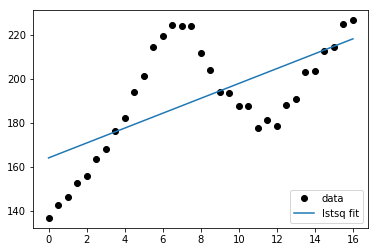

In [7]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(housing[:,0], housing[:,1], 'ko', label='data')
plt.plot(housing[:,0], fitted, label='lstsq fit')
plt.legend(loc='lower right')
plt.show()

### Exercise 3.

In [8]:
def poly_fit(a, b, degrees):
    '''
    a is a 1-d array that contains the data for the regressor
    '''
    betas = []
    for i in range(len(degrees)):
        p = degrees[i]
        design = np.vander(a, p)
        beta_hat = la.lstsq(design, b)[0]
        betas.append(beta_hat)
    
    return betas

In [9]:
degrees = [4, 7, 9, 13]
beta_hats  =  poly_fit(housing[:,0], housing[:,1], degrees)


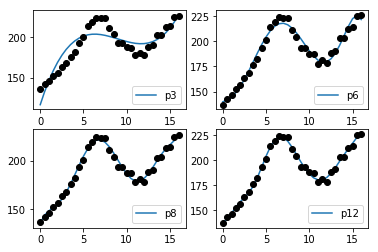

In [10]:
fig, axes = plt.subplots(2,2)
x = housing[:,0]
col=0
for i in range(2):
    for j in range(2):
        y = np.polyval(beta_hats[col], x)
        name = 'p{}'.format(len(beta_hats[col])-1)
        axes[i, j].plot(housing[:,0], y, label=name)
        axes[i, j].plot(housing[:,0], housing[:,1],'ko',)
        axes[i, j].legend()
        col +=1
plt.show()

#### These are my fitted polynomials.

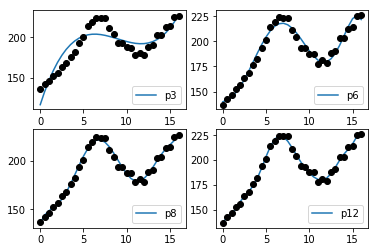

In [11]:
numpy_betas = []
for i in degrees:
    numpy_betas.append(np.polyfit(x, housing[:,1], i-1))
numpy_betas

fig, axes = plt.subplots(2,2)
x = housing[:,0]
col=0
for i in range(2):
    for j in range(2):
        y = np.polyval(numpy_betas[col], x)
        name = 'p{}'.format(len(beta_hats[col])-1)
        axes[i, j].plot(housing[:,0], y, label=name)
        axes[i, j].plot(housing[:,0], housing[:,1],'ko',)
        axes[i, j].legend()
        col +=1
plt.show()

#### And numpy's look exactly the same.

### Exercise 4.

In [12]:
x, y  = np.load('ellipse.npy').T

In [13]:
def fit_ellipse(x, y):
    x2, y2, xy = x**2, y**2, x*y
    A = np.column_stack((x2, x, xy, y, y2))
    a, b, c, d, e = la.lstsq(A, np.ones_like(x2))[0]
    return a, b, c, d, e

def plot_ellipse(a, b, c, d, e, x, y):
    """Plot an ellipse of the form ax^2 + bx + cxy + dy + ey^2 = 1."""
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A))/(2*A)
    plt.plot(r*cos_t, r*sin_t, lw=2)
    plt.plot(x, y, 'ko')
    plt.gca().set_aspect("equal", "datalim")

In [14]:
a, b, c, d, e = fit_ellipse(x, y)
a, b, c, d, e

(0.086961658367281647,
 -0.14135243784644649,
 0.15945721844270044,
 -0.31565012775213186,
 0.36615841702487978)

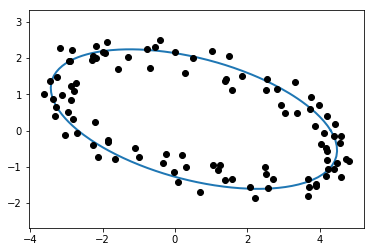

In [15]:
plt.figure()
plot_ellipse(a, b, c, d, e, x, y)
plt.show()

### Exercise 5.

In [16]:
def power_method(A, max_iter=1000, tol=1e-4):
    m, n = A.shape[0], A.shape[1]
    x0 = np.random.random(n)
    x0 = x0 / la.norm(x0)
    for k in range(max_iter-1):
        x_new = A @ x0
        x_new = x_new / la.norm(x_new)
        crit = la.norm(x0 - x_new)
        if crit < tol:
            break
        else:
            x0 = x_new.copy()
            del(x_new)
    dom_eigenval = x_new.T @ A @ x_new
    return dom_eigenval, x_new

In [17]:
A = np.random.random((10,10))
eigs, vecs = la.eig(A)
loc = np.argmax(eigs)
lamb, x = eigs[loc], vecs[:,loc]
np.allclose(A.dot(x), lamb*x)

True

In [18]:
lamb1, eigvec1 = power_method(A)
np.allclose(A.dot(eigvec1).round(3), np.round(lamb1*eigvec1, 3))

True

In [19]:
np.round(lamb,4) == np.round(lamb1, 4)

True

### Exercise 6.

In [20]:
def hessenberg(A):
    
    sign = lambda x: 1 if x >= 0 else -1
    
    m, n, = A.shape[0], A.shape[1]
    H = A.copy()
    Q = np.identity(m)
    
    for k in range(n-3):
        u = H[k+1:,k].copy()
        u[0] += sign(u[0]) * la.norm(u)
        u = u / la.norm(u)
        H[k+1:,k:] -= 2 * np.outer(u, u.T @ H[k+1:,k:])
        H[:,k+1:] -= 2 * np.outer(H[:,k+1:] @ u, u)
        Q[k+1:,:] -= 2 * np.outer(u, u.T @ Q[k+1:,:])
        
        return H, Q.T

In [21]:
import cmath

def qr_algorithm(A, N=1000, tol=1e-4):
    m, n, = A.shape[0], A.shape[1]
    S_old, _ = hessenberg(A)
    
    for k in range(N-1):
        Q, R, = la.qr(S_old)
        S = R @ Q
        
        eigs = []
        if la.norm(S - S_old) < tol:
            break
        i = 0
        while i < n:
            if i == n - 1:
                eigs.append(S[i,i])
            elif S[i+1,i] < tol:
                eigs.append(S[i,i])
            else:
                B = S[i:i+2, i:i+2]
                a, b, c, d = B[0,0], B[0, 1], B[1,0], B[1,1]
                ad2 = (a + d) / 2
                adbc = a * d - b * c 
                eig_1 = ad2 + cmath.sqrt(ad2 - adbc)
                eig_2 = ad2 - cmath.sqrt(ad2 - adbc)
                eigs.append([eig_1, eig_2])
                i += 1
            i += 1
            S_old = S.copy()
    return np.array([eigs])

In [22]:
A = np.random.random((5,5))
Asym = A + A.T
my_eigenvals = qr_algorithm(Asym)


eig, vecs = la.eig(Asym)

In [23]:
my_eigenvals

array([], shape=(1, 0), dtype=float64)

In [24]:
eig

array([ 5.84707496+0.j, -0.78840634+0.j,  0.73618993+0.j,  0.38453366+0.j,
       -0.13409663+0.j])